In [1]:
# package loading
import numpy as np
import random
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
import seaborn as sn

In [2]:
class QPlayer:
    "Class for a Q-Learning agent player"
    states_value = dict()
    def __init__(self, epsilon, alpha = 0.05, gamma = 0.99, player_name = 'O'):
        """
        Initializer
        INPUTS: 
        - epsilon: exploration level to define the epsilon-greedy policy; the agent takes the best action with probability 1-epsilon
        - alpha: learning rate
        - gamma: discount factor
        - player_name: player symbol on the board
        """
        self.epsilon = epsilon
        self.alpha = alpha 
        self.gamma = gamma 
        self.player_name = player_name 
        #self.states_value = dict() # dictionary that will store the Q-values at each status 
        
    def set_player(self, player_name = 'O', j=-1):
        """
        Function to set player symbol, needed to alternate the starting player.
        INPUTS:
        - player_name: player symbol on the board
        - j : number of the current game
        """
        self.player_name = player_name
        if j != -1:
            self.player_name = 'O' if j % 2 == 0 else 'X'
            
    def empty(self, grid):
        """
        Function to return available actions given a board situation.
        INPUTS: 
        - grid: current board status
        OUTPUTS:
        - avail: array with available actions
        """
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(i)
        return avail
    
    def get_state_key(self, grid):
        """
        Function transforing the grid configuration into a string, needed for use it as key of a dictionary.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - key: correspondent string
        """ 
        key = str(grid.reshape(3 * 3))
        return key
    
    def select_optimal_action(self, grid):
        """
        Function selecting the available action with the highest Q-value, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: action with the highest Q-value
        """
        avail_actions = self.empty(grid) # find all available actions
        key = self.get_state_key(grid) # get the string corresponding to the current state
        if key in self.states_value : 
            # IF THE STATE HAS ALREADY BEEN EXPLORED
            restricted_vector = self.states_value[key][avail_actions] # array with the Q-values of the available actions
            idx = np.argmax(restricted_vector).item() # position of maximum of restricted_vector
            move = avail_actions[idx] # move corresponding to the maximum
        else :
            # IF THE STATE IS EXPLORED FOR THE FIRST TIME
            self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
            move = self.select_random_action(grid) # pick randomly the action to do 
        return move
    
    def select_random_action(self,grid):
        """
        Function selecting a random available action, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: a random available action
        """
        key = self.get_state_key(grid) # get the string corresponding to the current state
        # IF THE STATE IS EXPLORED FOR THE FIRST TIME
        if key not in self.states_value:
                self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
        actions = self.empty(grid) # find all available actions
        move = random.choice(actions) # pick randomly the action to do
        return move
    
    def act(self,grid):
        """
        Function selecting an available action given a state following the epsilon-greedy policy.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: an available action
        """
        b = np.random.binomial(1,1-self.epsilon) # bernoull
        # choose the action with the highest Q-value with probability 1-epsilon
        if b == 1 : 
            return self.select_optimal_action(grid)
        else : 
            return self.select_random_action(grid)
        
    def set_epsilon(self, epsilon):
        """
        Functions that sets the exploration level.
        INPUTS:
        - epsilon: exploration level
        """
        self.epsilon = epsilon
 

In [60]:
class QLearning:
    "Class for learning from experts"
    def __init__(self, epsilon1, epsilon2, alpha = 0.05, gamma = 0.99):
        """
        Initializer
        INPUTS:
        - epsilon1: exploration level of q_player
        - epsilon2: exploration level of opponent
        - alpha: learning rate
        - gamma: discount factor
        """
        self.q_player = QPlayer(epsilon1, alpha, gamma)
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []
        
    def game(self, eps_q_player, eps_opponent_train = 0.5, eps_opponent_test = 0, flag = 'train'):
        """
        Function to play a single game, either in training or testing setting
        INPUTS:
        - eps_q_player: exploration level of q_player
        - eps_opponent_train: exploration level of opponent during training (default = 0.5)
        - eps_opponent_test: exploration level of opponent during testing (default = 0, corresponding to optimal player)
        - flag : to distinguish between training and testing
        """
        self.env.reset() # reset the game
        
        # setting the exploration levels
        if flag == 'train':
            self.q_player.epsilon = eps_q_player
            self.opponent.epsilon = eps_opponent_train
        else :
            self.q_player.epsilon = 0
            self.opponent.epsilon = eps_opponent_test
            
        
        while not self.env.end : 
            # if the q_player has to play
            if self.env.current_player == self.q_player.player_name : 
                if flag == 'train':  
                    state_prec = self.env.grid.copy()
                # perform the move    
                move_q = self.q_player.act(self.env.grid)
                self.env.step(move_q)
                
            # if the opponent has to play
            else : 
                # perform the move
                move = self.opponent.act(self.env.grid)
                self.env.step(move)
                state = self.env.grid.copy()
                
                if flag == 'train' and self.env.num_step > 1:                    
                    self.update_q(self.q_player.player_name, state_prec, state, move_q)
                    
            if self.env.current_player == self.opponent.player and self.env.end and flag == 'train': 
                self.update_q(self.q_player.player_name, state_prec, self.env.grid, move_q)
        #if flag == 'test' and eps_opponent_test == 0:
        #    self.env.render()
        #    print('Winner: ', self.env.winner)
        #    print('Current q player:', self.q_player.player_name)  
        #    print('Reward: ', self.env.reward(self.q_player.player_name))      
        return self.env.reward(self.q_player.player_name)
        
        
    def update_q(self, player_name, state_prec, state, move_q):
        """
        Function updating the table of Q-values
        INPUT:
        - player: id of the player
        - states: array with states visited by the agent
        - actions: array with actions performed by the agent
        """
        r = self.env.reward(player_name) # get the reward of the q_player 
        
        # the Q-values table of the terminal state is initialized with zeros
        key = self.q_player.get_state_key(state)
        key_prec = self.q_player.get_state_key(state_prec)
        # check if the state is already present 
        if key not in self.q_player.states_value:
            self.q_player.states_value[key] = np.zeros([9,1])
        if key_prec not in self.q_player.states_value:
            self.q_player.states_value[key_prec] = np.zeros([9,1])
            
        # update Q(s,a)
        self.q_player.states_value[key_prec][move_q] += self.q_player.alpha*(r + self.q_player.gamma*max(self.q_player.states_value[key])-self.q_player.states_value[key_prec][move_q])  
        
    def play_n_games(self, n, epsilon, eps_opponent_train = 0.5, ntt = 0, get_reward = True):
        """
        Function to play n games and compute average reward during training
        INPUTS:
        - n: number of games to play
        - epsilon: exploration level of Q-player
        - ntt: total number of training games (default to 0)
        - get_reward: true if we want to store the averaged reward
        """
        r = 0
        for i in range(n):
            # since X always plays first, we need to exchange the id corresponding to the player each time
            self.q_player.set_player('O',i)
            self.opponent.set_player('X',i)
            # store reward of the current game
            r += self.game(epsilon[i+ntt], eps_opponent_train = eps_opponent_train, flag = 'train')
            # every 250 games, compute and store the averaged reward
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0 # re-inizialize the variable for the cumulated sum
                
    def play_train_test(self, epsilon, eps_opponent_train = 0.5, n_train = 250, n_tot_train = 20000, n_test = 500):
        """
        Function to play n_tot_train games and compute average reward every n_train games with n_test test games
        INPUTS:
        - epsilon: exploration level of Q-player
        - n_train: frequence of performing the testing during training
        - n_tot_train: total number of training games
        - n_test: number of games to test with
        OUTPUTS:
        - M_opt_vec: array with averaged rewards on n_test games against the OPTIMAL player, computed each n_train games during training
        - M_rand_vec: array with averaged rewards on n_test games against the OPTIMAL player, computed each n_train games during training
        """
        ntt = 0 # index of training game
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            # play n_train training games
            self.play_n_games(n_train , epsilon, eps_opponent_train = eps_opponent_train, ntt = ntt, get_reward = False)
            # each n_train games, perform the test
            if ntt!=0 and ntt%n_train == 0 :
                M_rand_vec.append(self.test(n_test,1))
                M_opt_vec.append(self.test(n_test,0))
            # update the effective number of training games
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon_opp):
        """
        Function to play n_test games
        INPUTS:
        - n_test: number of test games
        - epsilon: exploration level of the opponent
        OUTPUTS:
        - M/n_test: averaged reward
        """
        M = 0
        for i in range(n_test):
            self.q_player.set_player('O',i)
            self.opponent.set_player('X',i)
            new_game = self.game(0, eps_opponent_test = epsilon_opp, flag = 'test')
            M += new_game
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        xx = np.arange(step,n+1,step)
        yy = self.reward_vec
        fig = plt.figure()
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self,N_star, n, rewards, step = 250):
        xx = np.arange(step,n+1,step)
        fig = plt.figure()
        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]), linewidth=1, )
        plt.legend()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("plotnstar_thick.png")

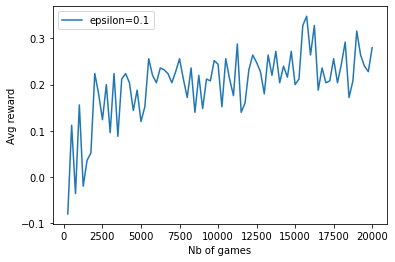

In [4]:
## Question 1
np.random.seed(2022)
random.seed(2022)
eps_vector = [0.1]
rew_epsilon = []

N = 20000
for epsilon in eps_vector:
    game = QLearning(epsilon,0.5)
    game.q_player.states_value = dict()
    game.play_n_games(N, epsilon*np.ones(N))
    game.plot_avg_reward(N,epsilon)
    rew_epsilon.append(game.reward_vec)

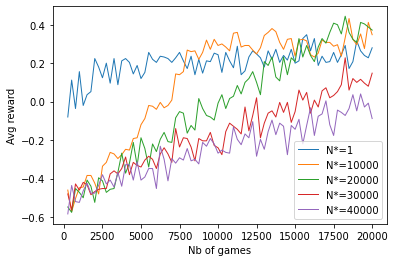

In [5]:
# Question 2
np.random.seed(2022)
random.seed(2022)
e_min = 0.1
e_max = 0.8
rew_N_star = []
N = 20000
N_star_vec = [1, 10000, 20000, 30000,40000]
for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = QLearning(0,0.5)
    game.q_player.states_value = dict()
    game.play_n_games(N,epsilon)
    rew_N_star.append(game.reward_vec)
game.plot_N_star_reward(N_star_vec,N,rew_N_star)
    

KeyboardInterrupt: 

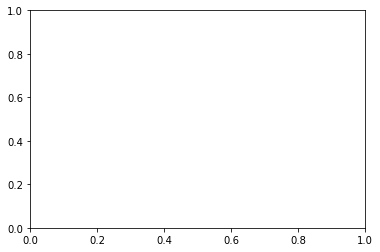

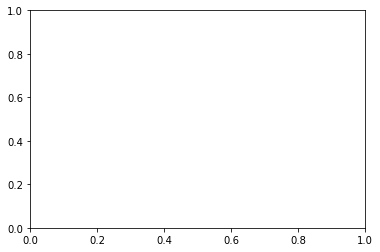

In [63]:
## Question 3
np.random.seed(21)
random.seed(21)
e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1,10000,20000,30000,40000]
plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()
for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = QLearning(epsilon, 0.5)
    game.q_player.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, n_train = 250, n_tot_train = N, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'N*='+str(N_star))
    ax1.set_title('M_opt')
    plt1.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'N*='+str(N_star))
    plt2.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.set_title('M_rand')

In [38]:
len(M_opt_vec)
len(M_rand_vec)

7

KeyboardInterrupt: 

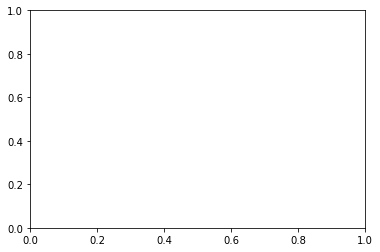

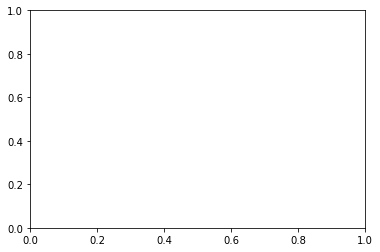

In [62]:
## Question 4
np.random.seed(2022)
random.seed(2022)
epsilon = []
e_min = 0.1
e_max = 0.8
n_tot_train = 20000
N_star = 10000 # DA TROVARE

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

for i in np.arange(1,n_tot_train+1):
    epsilon.append(max(e_min,e_max*(1-i/N_star)))
    
eps_opt = [0, 0.2, 0.4, 0.6, 0.8, 1]
for eps in eps_opt:
    game = QLearning(0, eps)
    game.q_player.states_value = dict()
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, eps_opponent_train = eps, n_train = 250, n_tot_train = 20000, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'eps='+str(eps))
    ax1.set_title('M_opt')
    plt1.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'eps='+str(eps))
    plt2.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.set_title('M_rand')

In [ ]:
class SelfQLearning:
    def __init__(self, epsilon1, epsilon2 = 0.5, alpha = 0.05, gamma = 0.99):
        self.q_player1 = QPlayer(epsilon1, alpha, gamma, player_name = 'O')
        self.q_player2 = QPlayer(epsilon1, alpha, gamma, player_name = 'X')
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []
        
    def game(self, eps_q_player, eps_opponent_test = 0, flag = 'train'):
        self.env.reset()
        
        states = []
        states.append(self.env.grid)
        if flag == 'train':
            self.q_player1.epsilon = eps_q_player
            self.q_player2.epsilon = eps_q_player
        else :
            self.q_player1.epsilon = 0
            self.opponent.epsilon = eps_opponent_test
            
        
        while not self.env.end : 
            if self.env.current_player == self.q_player1.player_name :   
                state_prec1 = self.env.grid.copy()
                move1 = self.q_player1.act(self.env.grid)
                self.env.step(move1)
                state2 = self.env.grid.copy()
                if flag == 'train': 
                    states.append(self.env.grid)
                    
            else : 
                if flag == 'test':
                    move = self.opponent.act(self.env.grid)
                    self.env.step(move)
                else :
                    state_prec2 = self.env.grid.copy()
                    move2 = self.q_player2.act(self.env.grid)
                    self.env.step(move2)
                    state1 = self.env.grid.copy()
                    states.append(self.env.grid)                    
                
            if flag == 'train' and self.env.num_step > 1: 
                if self.env.current_player == self.q_player1.player_name :
                    self.update_q(state_prec1, state1, move1)
                else :
                    self.update_q(state_prec2, state2, move2)
                
        return self.env.reward(self.q_player1.player_name)
        
        
    def update_q(self, state_prec, state, move_q):
        """
        Function updating the table of Q-values
        INPUT:
        - player: id of the player
        - states: array with states visited by the agent
        - actions: array with actions performed by the agent
        """
        r = self.env.reward(self.env.current_player) # get the reward of the q_player 
        
        # the Q-values table of the terminal state is initialized with zeros
        key = self.q_player1.get_state_key(state)
        key_prec = self.q_player1.get_state_key(state_prec)
        # check if the state is already present 
        if key not in self.q_player1.states_value:
            self.q_player1.states_value[key] = np.zeros([9,1])
        if key_prec not in self.q_player1.states_value:
            self.q_player1.states_value[key_prec] = np.zeros([9,1])
            
        # update Q(s,a)
        self.q_player1.states_value[key_prec][move_q] += self.q_player1.alpha*(r + self.q_player1.gamma*max(self.q_player1.states_value[key])-self.q_player1.states_value[key_prec][move_q])  
            
            
    def play_n_games(self, n, epsilon, ntt = 0, get_reward = True):
        r = 0
        for i in range(n):
            self.q_player1.set_player('O',i)
            self.q_player2.set_player('X',i+1)
            r += self.game(epsilon[i+ntt], 0.5, flag = 'train')
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0
                
    def play_train_test(self, epsilon, n_train = 250, n_tot_train = 20000, n_test = 500):
        ntt = 0
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            self.play_n_games(n_train, epsilon, ntt, False)
            if ntt!=0 and ntt%n_train == 0 :
                M_opt_vec.append(self.test(n_test,0))
                M_rand_vec.append(self.test(n_test,1))
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon):
        M = 0
        for i in range(n_test):
            new_val = self.game(0, eps_opponent_test = epsilon, flag = 'test')
            if epsilon == 0 and new_val > 0. : 
                print(self.q_player1.player_name)
                self.env.observe()
                #print('Error:', new_val)
            M += new_val
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        xx = np.arange(step,n+1,step)
        #print(xx)
        yy = self.reward_vec
        #print(yy)
        #fig = plt.figure()
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        #fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self,N_star, n, rewards, step = 250):
        xx = np.arange(step,n+1,step)
        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]))
            plt.legend()
        

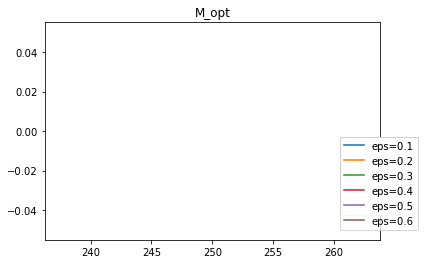

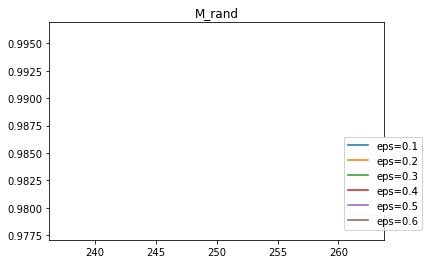

In [19]:
## Question 7
np.random.seed(2022)
random.seed(2022)
eps_vector = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
rew_epsilon = []


plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()



for epsilon in eps_vector:
    game = SelfQLearning(epsilon)
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon*np.ones(20000), n_train = 250, n_tot_train = 500, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'eps='+str(epsilon))
    ax1.set_title('M_opt')
    plt1.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'eps='+str(epsilon))
    plt2.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.set_title('M_rand')



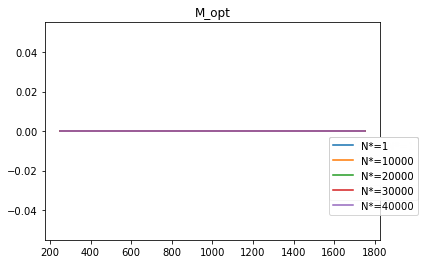

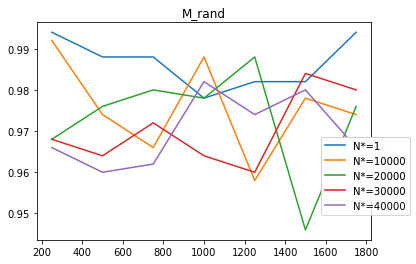

In [22]:
#Question 8
np.random.seed(2022)
random.seed(2022)

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1, 10000, 20000, 30000,40000]

for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = SelfQLearning(epsilon)
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon, n_train = 250, n_tot_train = N, n_test = 500)
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'N*='+str(N_star))
    ax1.set_title('M_opt')
    plt1.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'N*='+str(N_star))
    plt2.legend(loc = 'upper right', bbox_to_anchor = (1, 0.5))
    ax2.set_title('M_rand')






<AxesSubplot:>

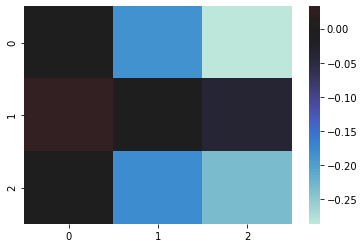

In [24]:
#Question 10
states1 = game.q_player1.get_state_key(np.array([[1, 0., 0.], [0., -1, 0.], [1, 0., 0.]]))
sn.heatmap(game.q_player1.states_value[states1].reshape(3,3), center=0)

<AxesSubplot:>

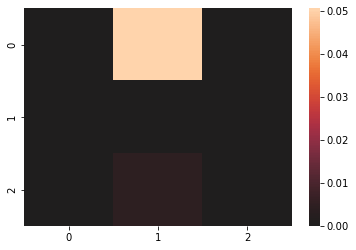

In [25]:
states2 = game.q_player1.get_state_key(np.array([[1, 0., 0.], [-1, -1, 1], [1, 0., 0.]]))
sn.heatmap(game.q_player1.states_value[states2].reshape(3,3), center=0)

<AxesSubplot:>

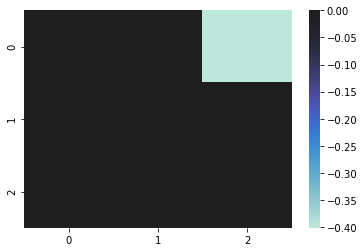

In [26]:
states3 = game.q_player1.get_state_key(np.array([[1, -1, 0.], [-1, -1, 1], [1, 1, 0.]]))
sn.heatmap(game.q_player1.states_value[states3].reshape(3,3), center=0)